In [ ]:
# !export CUDA_VISIBLE_DEVICES="1"
# !export CUDA_VISIBLE_DEVICES=1

In [ ]:
a = np.load("all_30s_sequences.npy", allow_pickle=True)

In [ ]:
len(a), len(a[:100])

In [2]:
from datetime import timedelta
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models,transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader,random_split
from __future__ import print_function
import numpy as np 
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt 
from torch.autograd import Function
from collections import OrderedDict
import torch.nn as nn
import math
import torchvision.models as models
import pickle
import cv2
import os
import sys
import glob
import collections
import pandas as pd
import wandb
from sklearn.model_selection import KFold
# from torchsummary import summary
import glob
from sklearn.manifold import TSNE
import seaborn as sns
import collections
from transformers import BertConfig, BertModel


import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random

SAVING_FRAMES_PER_SECOND = 30

In [2]:
VIDEO_FOLDER = "/media/data_cifs/nih/files_to_send/"
ACTION_FOLDER = "/media/data_cifs/nih/inference/results_csv/"

In [3]:
def cohort_search(cohort, search_root, ret=False):
    cohort = str(cohort).upper()
    all_folders = [folder for folder in os.listdir(search_root) if folder.startswith("FC-"+cohort)]
    all_folders.sort()
    all_folder_list = "\n".join(all_folders)
    if ret:
        return all_folders
    else:
        print(all_folder_list)

In [4]:
def find_mouse_videos(mouse_id, cohort, ret=False):
    
    search_for = "v"
    
    if search_for == "videos":
        print("Looking for videos..")
        file_extension = ".mp4" 
        ROOT_FOLDER = VIDEO_FOLDER
    else:
        print("Looking for actions...")
        file_extension = ".csv"
        ROOT_FOLDER = ACTION_FOLDER
    
    mouse_id = str(mouse_id)
    cohort_folders = cohort_search(cohort, ROOT_FOLDER, ret=True)
    
    preexposure_folders = [folder for folder in cohort_folders if "exp" in folder]
    postcond_folders = [folder for folder in cohort_folders if "cond" in folder]
    postext_folders = [folder for folder in cohort_folders if "xt" in folder]
    postret_folders = [folder for folder in cohort_folders if "tre" in folder]
    
    preexposure_videos = []
    postcond_videos = []
    postext_videos = []
    postret_videos = []
    
    for folder in preexposure_folders:
        preexposure_videos += [video+'/'+folder for video in os.listdir(ROOT_FOLDER+folder) if (mouse_id in video and video.endswith(file_extension) and os.stat(ROOT_FOLDER+folder+'/'+video).st_size)]
    preexposure_videos.sort()
    
    for folder in postcond_folders:
        postcond_videos += [video+'/'+folder for video in os.listdir(ROOT_FOLDER+folder) if (mouse_id in video and video.endswith(file_extension) and os.stat(ROOT_FOLDER+folder+'/'+video).st_size)]
    postcond_videos.sort()
    
    for folder in postext_folders:
        postext_videos += [video+'/'+folder for video in os.listdir(ROOT_FOLDER+folder) if (mouse_id in video and video.endswith(file_extension) and os.stat(ROOT_FOLDER+folder+'/'+video).st_size)]
    postext_videos.sort()
    
    for folder in postret_folders:
        postret_videos += [video+'/'+folder for video in os.listdir(ROOT_FOLDER+folder) if (mouse_id in video and video.endswith(file_extension) and os.stat(ROOT_FOLDER+folder+'/'+video).st_size)]
    postret_videos.sort()
    
    if ret:
        return preexposure_videos, postcond_videos
    else:
        print("\nPREEXPOSURE:")
        print("\n".join(preexposure_videos))
        print("\nPOSTCONDITIONING:")
        print("\n".join(postcond_videos))
        print("\nPOSTEXTINCTION:")
        print("\n".join(postext_videos))
        print("\nPOSTRETRIEVAL:")
        print("\n".join(postret_videos))

In [5]:
BEH_LABELS = ['drink', 'eat', 'groom', 'hang', 'sniff', 'rear', 'rest', 'walk', 'nibble']
action_colours = ['tab:blue', 'tab:orange', 'limegreen', 'deepskyblue', 'tab:pink', 'tab:purple', 'tab:brown', 'red', 'black']
len(action_colours) == len(BEH_LABELS)

True

In [ ]:
all_preexposure_actions_17202338_a = np.load("all_preexposure_actions_17202338_a.npy")

# for action_set in preexposure_actions_17202338_a:
#     for idx in range(len(action_set)):
#         all_preexposure_actions_17202338_a.append(action_set.iloc[idx][1])
print("Preexposure:", len(all_preexposure_actions_17202338_a))

all_postcond_actions_17202338_a = np.load("all_postcond_actions_17202338_a.npy")
# for action_set in postcond_actions_17202338_a:
#     for idx in range(len(action_set)):
#         all_postcond_actions_17202338_a.append(action_set.iloc[idx][1])
print("Postcond:", len(all_postcond_actions_17202338_a))

# all_postext_actions_17202338_a = []
# for action_set in postext_actions_17202338_a:
#     for idx in range(len(action_set)):
#         all_postext_actions_17202338_a.append(action_set.iloc[idx][1])
# print("Postext:", len(all_postext_actions_17202338_a))

# all_postret_actions_17202338_a = []
# for action_set in postret_actions_17202338_a:
#     for idx in range(len(action_set)):
#         all_postret_actions_17202338_a.append(action_set.iloc[idx][1])
# print("Postret:", len(all_postret_actions_17202338_a))

In [6]:
time_counter = {
    'under5':0,
    '5-10':0,
    '10-15':0,
    '15-20':0,
    '20-25':0,
    '25-30':0,
    '30-35':0,
    '35-40':0,
    '40-45':0,
    '45-50':0,
    '50-55':0,
    '55-60':0,
    '60-90':0,
    '90-450':0,
    '450-1800':0,
    '1800-4500':0,
    'over4500':0,}

def get_repeat_vocab(repeat_number):
    # > '0-5'
    # > '5-15'
    # > '15-45'
    # > '45-90'
    # > '90-450'
    # > '450-1800'
    # > '1800-4500'
    # > 'over4500'
    if repeat_number > 0 and repeat_number <= 5:
        box = "under5"
    elif repeat_number > 5 and repeat_number <= 10:
        box = "5-10"
    elif repeat_number > 10 and repeat_number <= 15:
        box = "10-15"
    elif repeat_number > 15 and repeat_number <= 20:
        box = "15-20"
    elif repeat_number > 20 and repeat_number <= 25:
        box = "20-25"
    elif repeat_number > 25 and repeat_number <= 30:
        box = "25-30"
    elif repeat_number > 30 and repeat_number <= 35:
        box = "30-35"
    elif repeat_number > 35 and repeat_number <= 40:
        box = "35-40"
    elif repeat_number > 40 and repeat_number <= 45:
        box = "40-45"
    elif repeat_number > 45 and repeat_number <= 50:
        box = "45-50"
    elif repeat_number > 50 and repeat_number <= 55:
        box = "50-55"
    elif repeat_number > 55 and repeat_number <= 60:
        box = "55-60"
    elif repeat_number > 60 and repeat_number <= 90:
        box = "60-90"
    elif repeat_number > 90 and repeat_number <= 450:
        box = "90-450"
    elif repeat_number > 450 and repeat_number <= 1800:
        box = "450-1800"
    elif repeat_number > 1800 and repeat_number <= 4500:
        box = "1800-4500"
    elif repeat_number > 4500:
        box = "over4500"
    else:
        raise ValueError('A very specific bad thing happened.')
    time_counter[box] += 1
    return box

In [7]:
def cleaning_actions(action_list):
    WINDOW_SIZE = 3 # Each side
    
    index = WINDOW_SIZE
    action_length = len(action_list)
    
    while index < (action_length - WINDOW_SIZE - 1):
        current_action = action_list[index]
        window = action_list[index - WINDOW_SIZE : index + WINDOW_SIZE + 1]
        window_elements = collections.Counter(window)
        most_common_action = window_elements.most_common(1)[0][0]
        if action_list[index] != most_common_action:
            action_list[index] = most_common_action
        index += 1
    return action_list

In [17]:
def generate_language_from_labels(action_list, class_label):
    SENTENCE_LENGTH = 600 # in terms of actions
    
    start_index = 0
    action_length = len(action_list)
    
    language = []
    label = []
    sentence = ""
    
    current_sentence_length = 0
    while start_index < action_length:
        
        current_action = action_list[start_index]
        current_action_label = BEH_LABELS[current_action]
        
        next_action_idx = start_index + 1
        
        while next_action_idx < action_length and current_action == action_list[next_action_idx]:
            next_action_idx  += 1
        repeats = next_action_idx - start_index
        
        # Filtering out single frame noise
#         if repeats == 1 and current_action != action_list[next_action_idx]:
#             start_index = next_action_idx
#             print("Single action:", action_list[next_action_idx-2], current_action, action_list[next_action_idx])
#             continue
        
        if current_sentence_length == 0:
            sentence = ""
            
        current_sentence_length += repeats
        start_index = next_action_idx
        
        sentence += str(current_action_label)+" "+get_repeat_vocab(repeats)+" "
        
        if current_sentence_length >= SENTENCE_LENGTH:
            language.append(sentence)
            label.append(class_label)
            current_sentence_length = 0
            
    if sentence != "":
        language.append(sentence)
        label.append(class_label)
    return language, label

In [9]:
all_preexposure_actions_17202338_d = np.load("all_preexposure_actions_17202338_d.npy")
all_postcond_actions_17202338_d = np.load("all_postcond_actions_17202338_d.npy")

In [18]:
all_preexposure_actions_17202338_a = np.load("all_preexposure_actions_17202338_a.npy")
all_postcond_actions_17202338_a = np.load("all_postcond_actions_17202338_a.npy")

In [10]:
cleaned_preexposure_d = cleaning_actions(all_preexposure_actions_17202338_d)
print("Preexposure done.")
cleaned_postcond_d = cleaning_actions(all_postcond_actions_17202338_d)
print("Postcond done.")

Preexposure done.
Postcond done.


In [19]:
cleaned_preexposure = cleaning_actions(all_preexposure_actions_17202338_a)
print("Preexposure done.")
cleaned_postcond = cleaning_actions(all_postcond_actions_17202338_a)
print("Postcond done.")

Preexposure done.
Postcond done.


In [20]:
raw_text = []
labels = []

preexposure = generate_language_from_labels(cleaned_preexposure, "preexposure")
postcond = generate_language_from_labels(cleaned_postcond, "postcond")

raw_text += preexposure[0]
labels += preexposure[1]

raw_text += postcond[0]
labels += postcond[1]

In [21]:
BEH_LABELS = ['drink', 'eat', 'groom', 'hang', 'sniff', 'rear', 'rest', 'walk', 'nibble']
action_colours = ['tab:blue', 'tab:orange', 'limegreen', 'deepskyblue', 'tab:pink', 'tab:purple', 'tab:brown', 'red', 'black']
len(action_colours) == len(BEH_LABELS)

True

In [13]:
raw_text_d = []
labels_d = []

preexposure_d = generate_language_from_labels(cleaned_preexposure_d, "preexposure")
postcond_d = generate_language_from_labels(cleaned_postcond_d, "postcond")

raw_text_d += preexposure_d[0]
labels_d += preexposure_d[1]

raw_text_d += postcond_d[0]
labels_d += postcond_d[1]

In [14]:
# Checking if labels are correct
len(raw_text_d), len(labels_d), len(raw_text_d) == len(labels_d)

(2602, 2602, True)

In [22]:
# Checking max sequence length and vocabulary
max_seq_len = 0
seq_lens = []
overall_set = set()
for seq in preexposure_d[0]:
    overall_set.update(seq.split())
    seq_lens.append(len(seq))
    if len(seq) > max_seq_len:
        max_seq_len = len(seq)
print("Maximum sequence length:", max_seq_len)
seq_lens = np.array(seq_lens)
print("Average:", np.mean(seq_lens))
print("Standard Deviation:", np.std(seq_lens))
print("Final Vocabulary:", overall_set)
print("Length of Vocabulary:", len(overall_set))

Maximum sequence length: 1102
Average: 416.8055342044581
Standard Deviation: 249.16358128425674
Final Vocabulary: {'sniff', '15-20', '50-55', 'walk', '35-40', 'drink', '55-60', 'over4500', '1800-4500', '30-35', '40-45', 'eat', '450-1800', 'hang', 'rest', '20-25', '45-50', 'rear', 'nibble', '90-450', 'under5', 'groom', '25-30', '60-90', '10-15', '5-10'}
Length of Vocabulary: 26


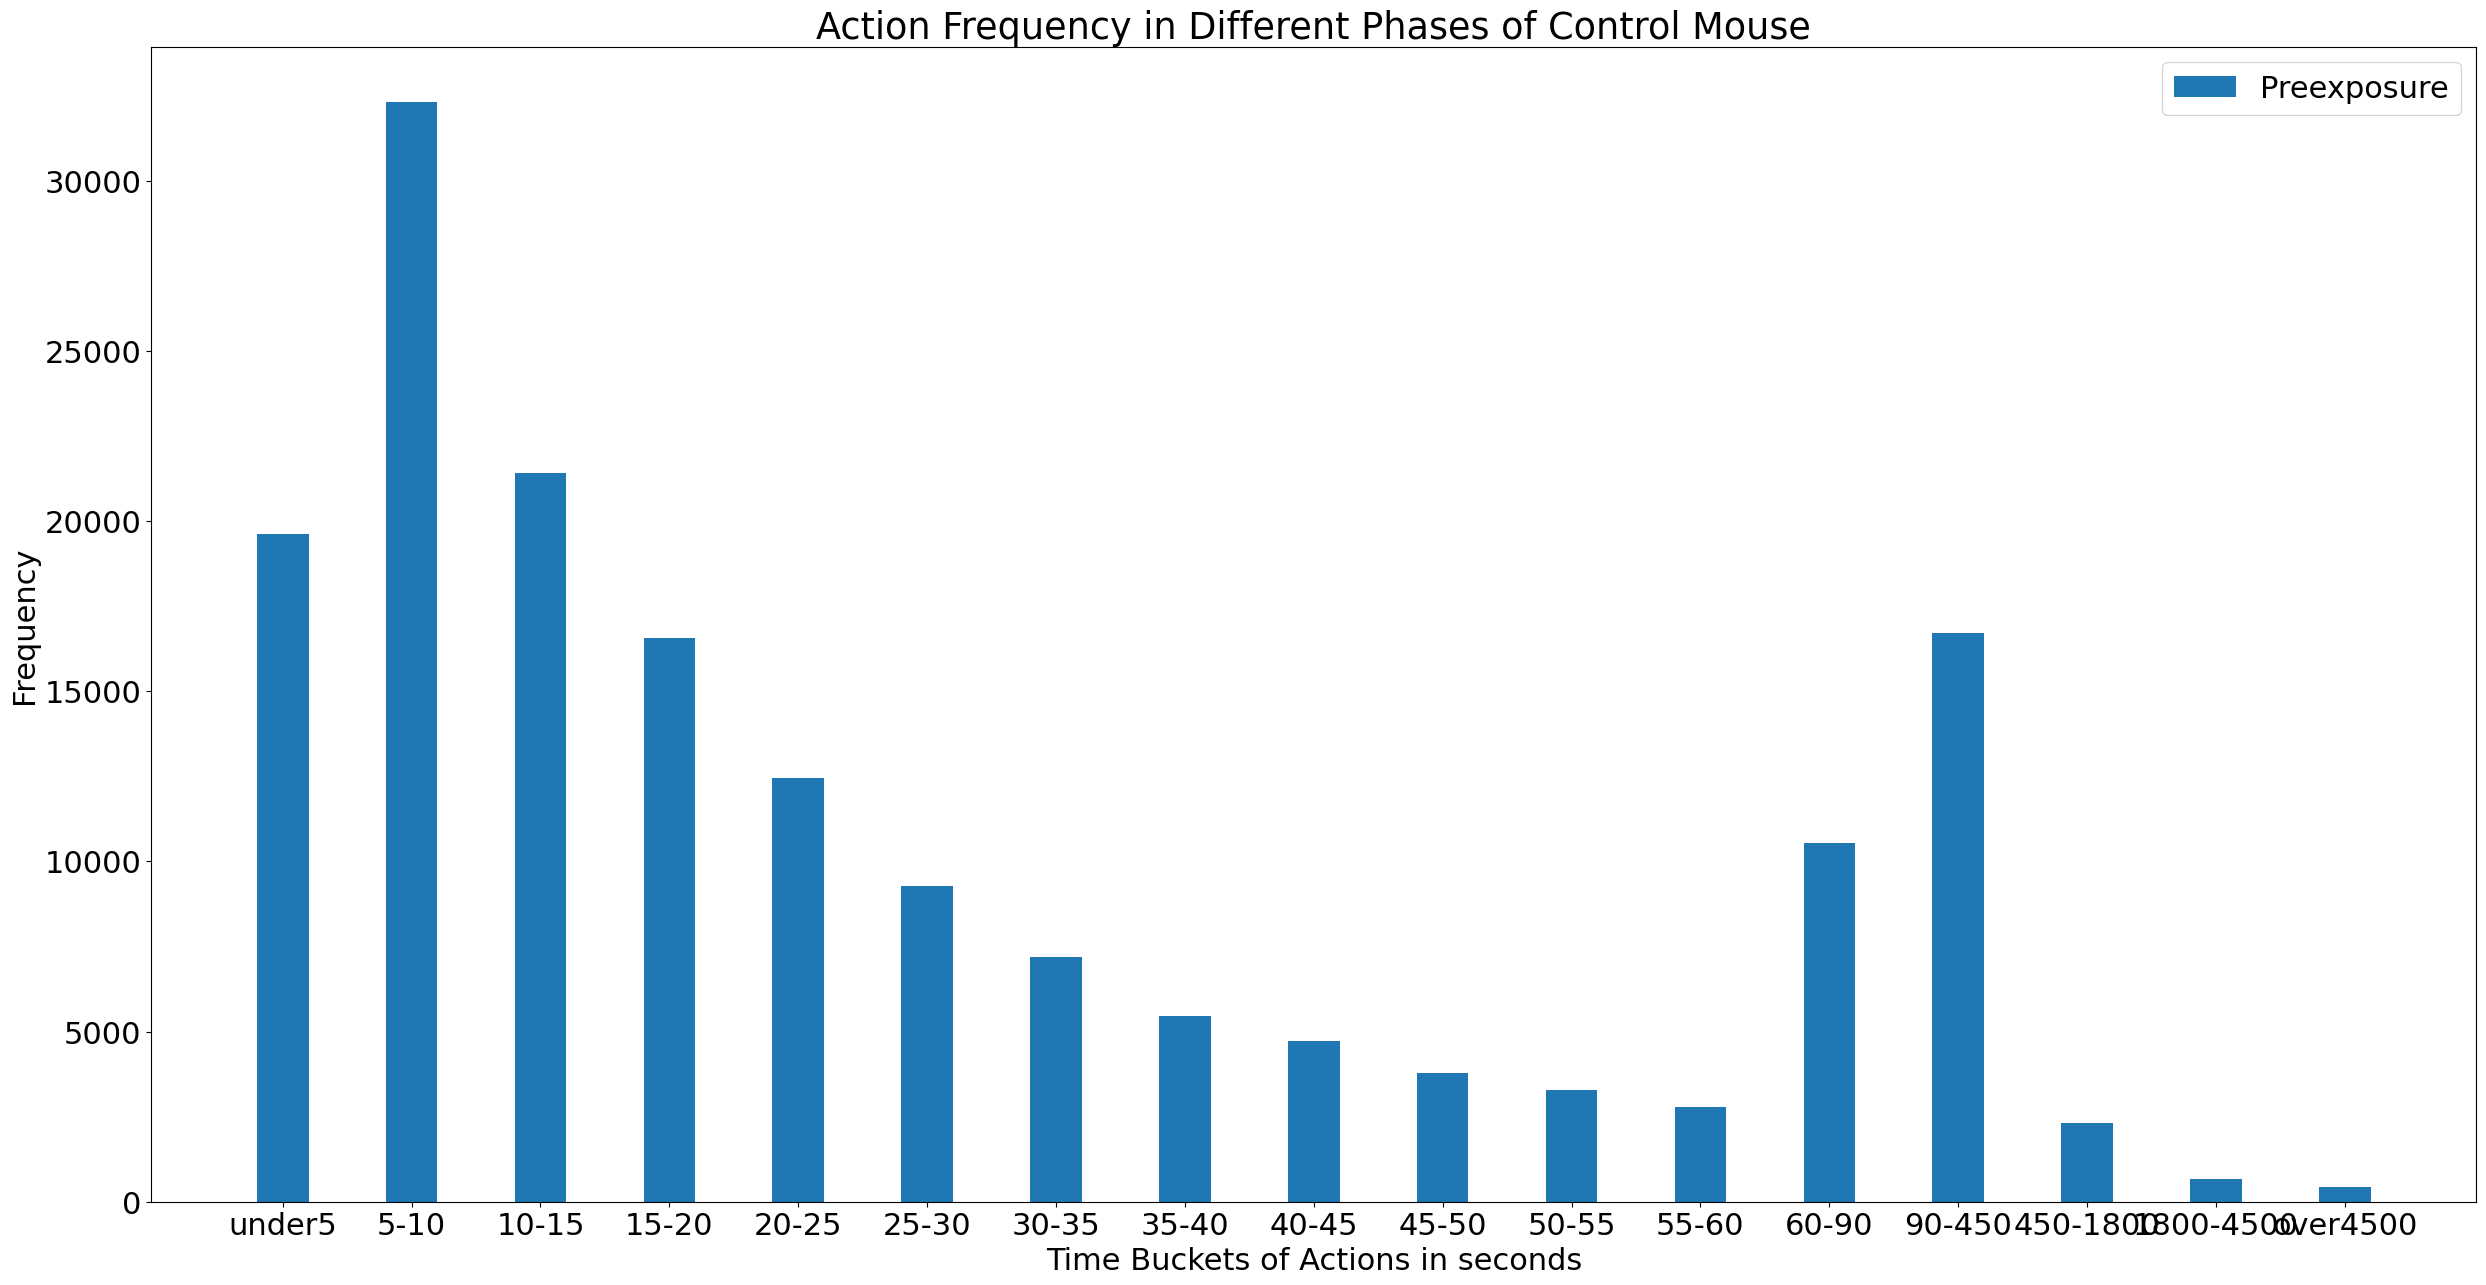

In [23]:
# Plot time distributions:
times = [time_counter[x] for x in time_counter.keys()]

X = [x for x in time_counter.keys()]
X_axis = np.arange(len(X))

plt.figure(figsize=(30, 15))
plt.rcParams.update({'font.size': 22})
plt.bar(X_axis , times, 0.4, label = 'Preexposure')

plt.xticks(X_axis, X)
plt.xlabel("Time Buckets of Actions in seconds")
plt.ylabel("Frequency")
plt.title("Action Frequency in Different Phases of Control Mouse")
plt.legend()
plt.show()

# Tokenizer

In [ ]:
!cat nih_vocab.txt

In [35]:
from transformers import BertTokenizer

# tokenizer = BertTokenizer("nih_vocab.txt", do_basic_tokenize=False)#.from_pretrained('bert-base-cased')
# tokenizer.add_tokens(["0-5", "10-15"])

example_text = 'walk under5 rest 5-10'
bert_input = tokenizer(example_text,padding='max_length', max_length = 512, 
                       truncation=True, return_tensors="pt")

In [36]:
tokenizer.get_vocab()

{'[PAD]': 0,
 '[unused0]': 1,
 '[unused1]': 2,
 '[unused2]': 3,
 '[unused3]': 4,
 '[unused4]': 5,
 '[unused5]': 6,
 '[unused6]': 7,
 '[unused7]': 8,
 '[unused8]': 9,
 '[unused9]': 10,
 '[unused10]': 11,
 '[unused11]': 12,
 '[unused12]': 13,
 '[unused13]': 14,
 '[unused14]': 15,
 '[unused15]': 16,
 '[unused16]': 17,
 '[unused17]': 18,
 '[unused18]': 19,
 '[unused19]': 20,
 '[unused20]': 21,
 '[unused21]': 22,
 '[unused22]': 23,
 '[unused23]': 24,
 '[unused24]': 25,
 '[unused25]': 26,
 '[unused26]': 27,
 '[unused27]': 28,
 '[unused28]': 29,
 '[unused29]': 30,
 '[unused30]': 31,
 '[unused31]': 32,
 '[unused32]': 33,
 '[unused33]': 34,
 '[unused34]': 35,
 '[unused35]': 36,
 '[unused36]': 37,
 '[unused37]': 38,
 '[unused38]': 39,
 '[unused39]': 40,
 '[unused40]': 41,
 '[unused41]': 42,
 '[unused42]': 43,
 '[unused43]': 44,
 '[unused44]': 45,
 '[unused45]': 46,
 '[unused46]': 47,
 '[unused47]': 48,
 '[unused48]': 49,
 '[unused49]': 50,
 '[unused50]': 51,
 '[unused51]': 52,
 '[unused52]': 53,

In [37]:
print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])


example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)

tensor([[ 101, 3328, 2104, 2629, 2717, 1019, 1011, 2184,  102,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

In [38]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
class_labels = {'preexposure':0,
          'postcond':1,
          }

In [39]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [class_labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [48]:
np.random.seed(112)
df = pd.DataFrame({"text": np.array(raw_text), "category": np.array(labels)})

df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

4602 575 576


In [49]:
df

,text,category
0,eat 10-15 hang 55-60 eat 60-90 hang 90-450 eat...,preexposure
1,eat 10-15 hang 5-10 eat 35-40 hang 60-90 eat u...,preexposure
2,eat 25-30 hang 60-90 eat 5-10 hang 20-25 eat 6...,preexposure
3,rear under5 sniff 10-15 rear under5 eat 90-450...,preexposure
4,hang 90-450 eat under5 hang 50-55 eat 15-20 re...,preexposure
...,...,...
5748,sniff 90-450 rest 10-15 sniff 15-20 rest under...,postcond
5749,walk 20-25 sniff 50-55 eat 50-55 sniff 15-20 g...,postcond
5750,eat 90-450 groom under5 sniff 90-450 rest 5-10...,postcond
5751,rest 10-15 sniff 15-20 groom 5-10 sniff 10-15 ...,postcond


In [50]:
example_text = tokenizer.decode(bert_input.input_ids[0])
print("Text:", bert_input.input_ids[0])
print(example_text)

Text: tensor([ 101, 3328, 2104, 2629, 2717, 1019, 1011, 2184,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   

In [57]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

#         self.bert = BertModel.from_pretrained(
#     'bert-base-uncased',
#     num_labels = 2)#BertModel.from_pretrained('bert-base-cased')
#         self.dropout = nn.Dropout(dropout)
#         self.linear = nn.Linear(768, 2)
#         self.relu = nn.ReLU()
        self.bert = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased',
            num_labels = 2,
            output_attentions = False,
            output_hidden_states = False,
        )


    def forward(self, input_id, mask):

        pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
#         dropout_output = self.dropout(pooled_output)
#         linear_output = self.linear(dropout_output)
#         final_layer = self.relu(linear_output)

        return pooled_output#final_layer

In [58]:
df_train

,text,category
1654,groom 5-10 rest 45-50 eat 1800-4500,preexposure
4763,rest 90-450 sniff 10-15 groom under5 sniff 5-1...,postcond
2778,sniff 30-35 groom 60-90 sniff 60-90 eat 5-10 s...,preexposure
4214,groom 60-90 rest over4500,postcond
3944,groom 90-450 sniff 60-90 groom 25-30 sniff 25-...,postcond
...,...,...
5201,groom 90-450 sniff 90-450 groom 15-20 sniff 5-...,postcond
1279,eat 10-15 groom 90-450 sniff under5 groom 90-4...,preexposure
5634,groom 25-30 sniff 35-40 groom 5-10 sniff 10-15...,postcond
1555,rest 60-90 sniff 5-10 groom 10-15 rest 60-90 g...,preexposure


In [66]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=16)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id,
                             attention_mask = mask, 
                             labels = train_label)#model(input_id, mask)
#                 print(output)
                
#                 batch_loss = criterion(output, train_label.long())
#                 total_loss_train += batch_loss.item()
                
#                 acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += output.loss.item()

                model.zero_grad()
                output.loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id,
                             attention_mask = mask, 
                             labels = val_label)#model(input_id, mask)

#                     batch_loss = criterion(output, val_label.long())
#                     total_loss_val += batch_loss.item()
                    
#                     acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += output.loss.item()
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 20
model = model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)#BertClassifier()
LR = 5e-1
           
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epochs: 1 | Train Loss:  0.000                 | Train Accuracy:  3.775                 | Val Loss:  0.000                 | Val Accuracy:  1.383


100%|██████████| 288/288 [01:43<00:00,  2.78it/s]


Epochs: 2 | Train Loss:  0.000                 | Train Accuracy:  4.205                 | Val Loss:  0.000                 | Val Accuracy:  0.531


 48%|████▊     | 139/288 [00:50<00:54,  2.75it/s]


KeyboardInterrupt: 

In [ ]:
!nvidia-smi

In [ ]:
i=np.array([0.2679, 0.6094, 0.3750, 0.5201, 0.4598, 0.5022, 0.5402, 0.4978, 0.6473, 0.5469, 0.6875, 0.6094, 0.7277, 0.6942])
o=np.array([0.44172627, 0.6050543, 0.42027402, 0.5237427, 0.4314428, 0.5368727, 0.5066131, 0.5131374, 0.54185885, 0.5483212, 0.53514344, 0.6374835, 0.57226306, 0.7295411])
o=np.array([0.29868713, 0.6477031,  0.35026756, 0.5564324,  0.44540575, 0.5117446,
  0.54121333, 0.50770676, 0.63838315, 0.5623305,  0.69604564, 0.62351227,
  0.6863016,  0.75760615])

In [ ]:
import math
import numpy as np

n = len(i)

ans = np.sum(np.square(i-o))/n
ans

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
            
            print("Loader:", test_dataloader.dataset[0])
            print("Test_Input:", test_input)
            print("Test_Label:", test_label)
            break
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            print("GT:", test_label, "Prediction:", output.argmax(dim=1))
            total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

In [ ]:
a[1]

In [ ]:
df_test.iloc[1527]["text"]

In [ ]:
df_test["text"][1527]

In [ ]:
tokenizer(df_test["text"][1527])

# Verifying Classifier

In [ ]:
VIDEO_FOLDER = "/media/data_cifs/nih/files_to_send/"
ACTION_FOLDER = "/media/data_cifs/nih/inference/results_csv/"

In [ ]:
def cohort_search(cohort, search_root, ret=False):
    cohort = str(cohort).upper()
    all_folders = [folder for folder in os.listdir(search_root) if folder.startswith("FC-"+cohort)]
    all_folders.sort()
    all_folder_list = "\n".join(all_folders)
    if ret:
        return all_folders
    else:
        print(all_folder_list)

In [ ]:
def find_mouse_videos(mouse_id, cohort, ret=False):
    
    search_for = "v"
    
    if search_for == "videos":
        print("Looking for videos..")
        file_extension = ".mp4" 
        ROOT_FOLDER = VIDEO_FOLDER
    else:
        print("Looking for actions...")
        file_extension = ".csv"
        ROOT_FOLDER = ACTION_FOLDER
    
    mouse_id = str(mouse_id)
    cohort_folders = cohort_search(cohort, ROOT_FOLDER, ret=True)
    
    preexposure_folders = [folder for folder in cohort_folders if "exp" in folder]
    postcond_folders = [folder for folder in cohort_folders if "cond" in folder]
    postext_folders = [folder for folder in cohort_folders if "xt" in folder]
    postret_folders = [folder for folder in cohort_folders if "tre" in folder]
    
    preexposure_videos = []
    postcond_videos = []
    postext_videos = []
    postret_videos = []
    
    for folder in preexposure_folders:
        preexposure_videos += [video+'/'+folder for video in os.listdir(ROOT_FOLDER+folder) if (mouse_id in video and video.endswith(file_extension) and os.stat(ROOT_FOLDER+folder+'/'+video).st_size)]
    preexposure_videos.sort()
    
    for folder in postcond_folders:
        postcond_videos += [video+'/'+folder for video in os.listdir(ROOT_FOLDER+folder) if (mouse_id in video and video.endswith(file_extension) and os.stat(ROOT_FOLDER+folder+'/'+video).st_size)]
    postcond_videos.sort()
    
    for folder in postext_folders:
        postext_videos += [video+'/'+folder for video in os.listdir(ROOT_FOLDER+folder) if (mouse_id in video and video.endswith(file_extension) and os.stat(ROOT_FOLDER+folder+'/'+video).st_size)]
    postext_videos.sort()
    
    for folder in postret_folders:
        postret_videos += [video+'/'+folder for video in os.listdir(ROOT_FOLDER+folder) if (mouse_id in video and video.endswith(file_extension) and os.stat(ROOT_FOLDER+folder+'/'+video).st_size)]
    postret_videos.sort()
    
    if ret:
        return preexposure_videos, postcond_videos
    else:
        print("\nPREEXPOSURE:")
        print("\n".join(preexposure_videos))
        print("\nPOSTCONDITIONING:")
        print("\n".join(postcond_videos))
        print("\nPOSTEXTINCTION:")
        print("\n".join(postext_videos))
        print("\nPOSTRETRIEVAL:")
        print("\n".join(postret_videos))
    
    

In [ ]:
find_mouse_videos(2338, "B")

In [ ]:
BEH_LABELS = ['drink', 'eat', 'groom', 'hang', 'sniff', 'rear', 'rest', 'walk', 'eathand']
action_colours = ['tab:blue', 'tab:orange', 'limegreen', 'deepskyblue', 'tab:pink', 'tab:purple', 'tab:brown', 'red', 'black']
len(action_colours) == len(BEH_LABELS)

In [ ]:
preexposure_video_list_17202338_b = ["video_2018Y_09M_19D_10h_02m_36s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_19D_11h_02m_39s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_19D_12h_02m_42s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_19D_13h_02m_45s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_19D_14h_02m_46s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_19D_15h_02m_49s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_19D_16h_02m_50s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_19D_17h_02m_51s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_19D_18h_02m_52s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_19D_19h_02m_53s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_19D_20h_02m_54s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_19D_21h_02m_55s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_19D_22h_02m_56s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_19D_23h_02m_56s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_00h_02m_57s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_01h_02m_58s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_02h_03m_00s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_03h_03m_01s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_04h_03m_02s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_05h_03m_03s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_06h_03m_04s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_07h_03m_05s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_08h_03m_05s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_09h_03m_06s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_10h_06m_00s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_11h_06m_03s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_12h_06m_05s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_13h_06m_06s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_14h_06m_08s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_15h_06m_09s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_16h_06m_09s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_17h_06m_10s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_18h_06m_11s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_19h_06m_12s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_20h_06m_13s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_21h_06m_13s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_22h_06m_14s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_20D_23h_06m_15s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_2",
"video_2018Y_09M_21D_00h_06m_16s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_3",
"video_2018Y_09M_21D_01h_06m_17s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_3",
"video_2018Y_09M_21D_02h_06m_18s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_3",
"video_2018Y_09M_21D_03h_06m_18s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_3",
"video_2018Y_09M_21D_04h_06m_19s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_3",
"video_2018Y_09M_21D_05h_06m_20s_cam_17202338-0000.csv/FC-B_1-6_Preexposure_09-17_09-21_3",
]


In [ ]:
preexposure_actions_17202338_b = []
for action_list in preexposure_video_list_17202338_b:
    folder_name = action_list.split('/')[-1]
    action_file = action_list.split('/')[0]
    csv_name = ACTION_FOLDER+folder_name+"/"+action_file
    actions = pd.read_csv(csv_name)
    preexposure_actions_17202338_b.append(actions)

print("Preexposure_b Files:", len(preexposure_actions_17202338_b))
print("Preexposure_b Actions look like this:", preexposure_actions_17202338_b[0])

In [ ]:
all_preexposure_actions_17202338_b = []
for action_set in preexposure_actions_17202338_b:
    for idx in range(len(action_set)):
        all_preexposure_actions_17202338_b.append(action_set.iloc[idx][1])
print("Preexposure_b:", len(all_preexposure_actions_17202338_b))

In [ ]:
cleaned_preexposure_b = cleaning_actions(all_preexposure_actions_17202338_b)
print("Preexposure_b done.")

In [ ]:
evaluate_text = []
evaluate_labels = []

preexposure_b = generate_language_from_labels(cleaned_preexposure_b, "preexposure")
# postcond = generate_language_from_labels(cleaned_postcond, 1)

evaluate_text += preexposure_b[0]
evaluate_labels += preexposure_b[1]

# raw_text += postcond[0]
# labels += postcond[1]

In [ ]:
np.random.seed(112)
df_eval = pd.DataFrame({"text": np.array(evaluate_text), "category": np.array(evaluate_labels)})


print(len(df_eval))

In [ ]:
df_eval

In [ ]:
evaluate(model, df_eval)

# Evaluate on Different Mouse Post Cond

In [ ]:
test = Dataset(df_eval)

test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
print(df_eval.iloc[0])
print("TEST:",test[0][1])

In [ ]:
postcond_video_list_17202338_b = [""video_2018Y_09M_21D_10h_39m_26s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23",
"video_2018Y_09M_21D_11h_39m_30s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23",
"video_2018Y_09M_21D_12h_39m_32s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23",
"video_2018Y_09M_21D_13h_39m_35s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23",
"video_2018Y_09M_21D_14h_39m_37s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23",
"video_2018Y_09M_21D_15h_39m_39s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23",
"video_2018Y_09M_21D_16h_39m_40s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23",
"video_2018Y_09M_21D_17h_39m_40s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23",
"video_2018Y_09M_21D_18h_39m_41s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23",
"video_2018Y_09M_21D_19h_39m_42s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23",
"video_2018Y_09M_21D_20h_39m_42s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23",
"video_2018Y_09M_21D_21h_39m_43s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23",
"video_2018Y_09M_21D_22h_39m_44s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_21D_23h_39m_45s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_00h_39m_45s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_01h_39m_46s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_02h_39m_47s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_03h_39m_47s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_04h_39m_48s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_05h_39m_49s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_06h_39m_49s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_07h_39m_50s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_08h_39m_51s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_09h_39m_51s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_10h_39m_52s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_11h_39m_53s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_12h_39m_54s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_13h_39m_54s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_14h_39m_55s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_15h_39m_55s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_16h_39m_56s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_17h_39m_57s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_18h_39m_57s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_19h_39m_58s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_20h_39m_59s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_21h_39m_59s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_22h_40m_00s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_22D_23h_40m_00s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_00h_40m_01s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_01h_40m_02s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_02h_40m_02s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_03h_40m_03s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_04h_40m_04s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_05h_40m_04s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_06h_40m_05s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_07h_40m_05s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_08h_40m_06s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_09h_40m_07s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_10h_40m_07s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_11h_40m_08s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_12h_40m_09s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_13h_40m_10s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_14h_40m_10s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_15h_40m_11s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_16h_40m_12s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_17h_40m_12s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_18h_40m_13s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_19h_40m_14s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_20h_40m_14s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_21h_40m_15s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_22h_40m_16s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_23D_23h_40m_17s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_24D_00h_40m_17s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_24D_01h_40m_18s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_24D_02h_40m_19s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_24D_03h_40m_19s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_24D_04h_40m_20s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_24D_05h_40m_21s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_24D_06h_40m_21s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
"video_2018Y_09M_24D_07h_40m_22s_cam_17202338-0000.csv/FC-B_1-6_postcond_09-21_09-23_2",
]
